# Sharma et al. (2009)

In which the GMPE of Sharma et al. (2009) is implemented. First coefficient tables are reprocessed for cut & paste in to the .py source code. Then, key figures in the original paper are reproduced for validation. Finally, test vectors are produced for automatic code verification using unittest.

In [1]:
%matplotlib inline
%load_ext autoreload
import os
import warnings
import pandas as pd
import numpy as np
import csv as csv
#import toolbox as tb
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from scipy.constants import g
import importlib

from openquake.hazardlib import geo, mfd, tom, pmf, imt, const, gsim, tests
import openquake.hazardlib.source as src
import openquake.hazardlib.scalerel as msr
import openquake.hazardlib.site as sit

from openquake.hazardlib.gsim.sharma_2009 import SharmaEtAl2009

for item in gsim.get_available_gsims().values():
    importlib.import_module(item.__module__, item.__name__)
    try:
        importlib.import_module(item.__module__.replace('.gsim','.tests.gsim') + '_test', item.__name__ + 'TestCase')
        #print 'imported', item.__name__ + 'TestCase'
    except ImportError:
        #print 'from', item.__module__.replace('.gsim','.tests.gsim') + '_test', 'import', item.__name__ + 'TestCase failed ...'
        pass


/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/geo/geodetic.py:625: RuntimeWarning: geodetic speedups are not available
  warnings.warn("geodetic speedups are not available", RuntimeWarning)
/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/geo/utils.py:382: RuntimeWarning: geoutils speedups are not available
  warnings.warn("geoutils speedups are not available", RuntimeWarning)


In [2]:
df_coeffs = pd.DataFrame.from_csv('Tables/Table2.csv', index_col=None)
df_coeffs

,T,b1,std1,b2,std2,b3,std3,b5,std4,b6,std6,sigma
0,0.04,1.0170,0.3164,0.1046,0.0419,-1.0070,0.1368,-0.0735,0.0431,-0.3068,0.0409,0.3227
1,0.05,1.0280,0.3178,0.1245,0.0421,-1.0550,0.1374,-0.0775,0.0433,-0.3246,0.0411,0.3350
2,0.10,1.3820,0.3165,0.1041,0.0419,-1.0620,0.1368,-0.1358,0.0432,-0.3326,0.0409,0.3427
3,0.20,1.3820,0.3165,0.1041,0.0419,-1.0620,0.1368,-0.1358,0.0432,-0.3326,0.0409,0.3596
4,0.30,1.3680,0.3977,0.0684,0.0527,-0.9139,0.1720,-0.0972,0.0542,-0.3011,0.0514,0.3651
5,0.40,0.9747,0.3675,0.1009,0.0487,-0.8886,0.1589,-0.0552,0.0501,-0.2639,0.0475,0.3613
6,0.50,0.5295,0.3876,0.1513,0.0514,-0.8601,0.1676,-0.0693,0.0529,-0.2533,0.0501,0.3654
7,0.75,-0.5790,0.4079,0.3147,0.0541,-0.9064,0.1764,-0.0111,0.0556,-0.2394,0.0527,0.3770
8,1.00,-1.6120,0.3922,0.4673,0.0520,-0.9278,0.1696,-0.0203,0.0535,-0.2355,0.0507,0.3949
9,1.25,-1.7160,0.4250,0.4763,0.0563,-0.9482,0.1838,-0.0200,0.0580,-0.2921,0.0549,0.4190


In [3]:
df_coeffs2 = pd.DataFrame.from_csv('sharma coefficients.csv', index_col=None)
df_coeffs2

,T,b1,b2,b3,b4,b5
0,0.04,1.0170,0.1046,1.0070,-0.0735,-0.3068
1,0.05,1.0280,0.1245,1.0550,-0.0775,-0.3246
2,0.10,1.3820,0.1041,1.0620,-0.1358,-0.3326
3,0.20,1.3820,0.1041,1.0620,-0.1358,-0.3526
4,0.30,1.3680,0.0684,0.9139,-0.0972,-0.3011
5,0.40,0.9747,0.1009,0.8886,-0.0552,-0.2639
6,0.50,0.5295,0.1513,0.8601,-0.0693,-0.2533
7,0.75,-0.5790,0.3147,0.9064,-0.0111,-0.2394
8,1.00,-1.6120,0.4673,0.9278,-0.0203,-0.2355
9,1.25,-1.7160,0.4763,0.9482,-0.0200,-0.2921


In [4]:
# how peculiar that there is just one repeated row (except for sigma) ...
# no mention of coefficients being reused for 0.1 and 0.2 s in the paper ...
df_coeffs2.diff() == 0

,T,b1,b2,b3,b4,b5
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,True,True,True,True,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False


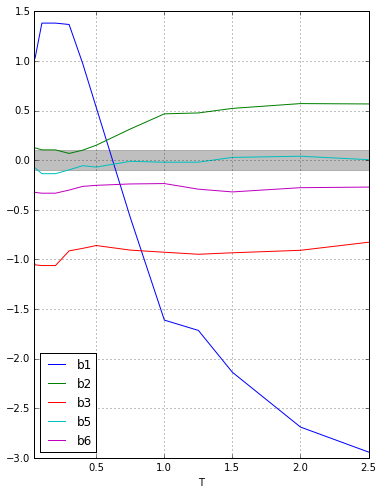

In [5]:
coefficients = ['b%d' for i in range(1,7)]
df_coeffs.plot(x='T', y=['b1', 'b2', 'b3', 'b5', 'b6'], figsize=(6, 8), grid=True)
plt.axhspan(-0.1, 0.1, color='0.5', alpha=0.5)
plt.savefig('Sharma_coefficients.pdf', dpi=300, bbox_inches='tight')

In [6]:
with open('Table2.txt','w') as f:
    f.write(df_coeffs[['T', 'b1', 'b2', 'b3', 'b5', 'b6', 'sigma']].to_string(index=False))

In [7]:
%autoreload 2
gmpe = SharmaEtAl2009()
print(type(gmpe).__name__)
print('Supported tectonic region: %s' 
      % gmpe.DEFINED_FOR_TECTONIC_REGION_TYPE)
print('Supported intensity measure types: %s' 
      % ', '.join([item.__name__ for item 
                   in gmpe.DEFINED_FOR_INTENSITY_MEASURE_TYPES]))
print('Supported component: %s' 
      % gmpe.DEFINED_FOR_INTENSITY_MEASURE_COMPONENT)
print('Supported standard deviations: %s' 
      % ', '.join([item for item              
                   in gmpe.DEFINED_FOR_STANDARD_DEVIATION_TYPES]))
print('Required site parameters: %s' 
      % ', '.join([item for item in gmpe.REQUIRES_SITES_PARAMETERS]))
print('Required rupture parameters: %s' 
      % ', '.join([item for item in gmpe.REQUIRES_RUPTURE_PARAMETERS]))
print('Required distance parameters: %s' 
      % ', '.join([item for item in gmpe.REQUIRES_DISTANCES]))

SharmaEtAl2009
Supported tectonic region: Active Shallow Crust
Supported intensity measure types: SA
Supported component: Average horizontal
Supported standard deviations: Total
Required site parameters: vs30
Required rupture parameters: rake, mag
Required distance parameters: rjb


In [8]:
def summarize(obj):
    print '\n'.join("%s: %s" % (item, getattr(obj, item))
                    for item in dir(obj) if item[0] != '_')
    
def isnumeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [9]:
# fixed parameters
tectonic_region_type = 'Active Shallow Crust'
hypo_lon = 0 # degrees
hypo_lat = 0 # degrees
hypo_depth = 12.5 # km
uncertainty_types = [const.StdDev.TOTAL]

# set things up so that Rjb is epicentral distance
site_azimuth = 0 # degrees
hypo_strike = 90 # degrees
hypo_dip = 90 # degrees


In [10]:
def compute_gmpe_overcomplicated(gmpe, mags, rakes, distances, vs30s, im_types):
    
    # set up sources
    mechanisms = [geo.NodalPlane(strike=hypo_strike, 
                                 dip=hypo_dip, rake=rake) 
                  for rake in rakes]
    prob = 1./len(rakes)
    nodal_plane_dist = pmf.PMF([(prob, mech) 
                                for mech in mechanisms])

    # derived parameters
    if np.array(mags).size > 1:
        delta_m = np.mean(np.diff(mags))
    else:
        delta_m = 1.
    mag_freq_dist = mfd.TruncatedGRMFD(
        min_mag=mags.min() - delta_m/2, 
        max_mag=mags.max() + delta_m/2, 
        bin_width=delta_m, 
        a_val=5.0, b_val=1.0),

    hypocenter = geo.Point(hypo_lon, hypo_lat, hypo_depth)

    source = src.PointSource(
        source_id='1',
        name='test',
        tectonic_region_type=tectonic_region_type,
        mfd=mag_freq_dist[0],
        rupture_mesh_spacing=2.,
        magnitude_scaling_relationship=msr.WC1994(),
        rupture_aspect_ratio=1.,
        temporal_occurrence_model=tom.PoissonTOM(50.),
        upper_seismogenic_depth=0.2*hypo_depth,
        lower_seismogenic_depth=2*hypo_depth,
        location=hypocenter,
        nodal_plane_distribution=nodal_plane_dist,
        hypocenter_distribution=pmf.PMF([(1, hypo_depth)]))

    # set up sites
    lons, lats = geo.geodetic.point_at(hypo_lon, hypo_lat, 
                                       site_azimuth, distances)
    site_locations = [geo.Point(lon, lat) for lon, lat in zip(lons, lats)]
    site_list = [sit.Site(location=loc, vs30=vs30, 
                    vs30measured=True, z1pt0=40., z2pt5=1.0) 
                 for vs30 in vs30s 
                 for loc in site_locations]
    site_collection = sit.SiteCollection(site_list)

    # compute ground motion
    context_maker = gsim.base.ContextMaker([gmpe])
    empty = True
    for rupture in source.iter_ruptures():

        # tweak required because ``min_mag`` and ``max_mag`` are rounded by 
        # TruncatedGRMFD so that  both are divisible by ``bin_width``
        rupture.mag = rupture.mag - delta_m/2.
        sctx, rctx, dctx = context_maker.make_contexts(
            site_collection, rupture)
        for i, im_type in enumerate(im_types):
            mean, [stddev] = gmpe.get_mean_and_stddevs(
                sctx, rctx, dctx, im_type, uncertainty_types)
            if i == 0:
                df_mean = pd.DataFrame({
                    'rup_mag': np.full_like(mean, rctx.mag),
                    'rup_rake': np.full_like(mean, rctx.rake),
                    'dist_rjb': dctx.rjb,
                    'site_vs30': sctx.vs30,
                    'damping': im_type.damping,
                        'S': (gmpe.get_site_type_dummy_variables(sctx)).astype('float'),
                        'H': np.full_like(mean, float(gmpe.get_fault_type_dummy_variables(rctx)))})
                df_stddev = df_mean.copy()
                df_mean['result_type'] = 'MEAN'
                df_stddev['result_type'] = 'TOTAL_STDDEV'
            df_mean[str(im_type.period)] = np.exp(mean)
            df_stddev[str(im_type.period)] = np.exp(stddev)
        if empty:
            df_means = df_mean
            df_stddevs = df_stddev
            empty = False
        else:
            df_means = pd.concat((df_means, df_mean), ignore_index=True)
            df_stddevs = pd.concat((df_stddevs, df_stddev), ignore_index=True)
    
    df_means.sort(['rup_rake','site_vs30','rup_mag','dist_rjb'], inplace=True)
    df_stddevs.sort(['rup_rake','site_vs30','rup_mag','dist_rjb'], inplace=True)
    df_means.index = range(len(df_means))
    df_stddevs.index = range(len(df_stddevs))
        
    #df_means = df_means.set_index(['rup_rake','site_vs30','rup_mag','dist_rjb']).sort()
    #df_stddevs = df_stddevs.set_index(['rup_rake','site_vs30','rup_mag','dist_rjb']).sort()

    return (df_means, df_stddevs)

In [11]:
def compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types):
    
    rctx = gsim.base.RuptureContext()
    sctx = gsim.base.SitesContext()
    dctx = gsim.base.DistancesContext()

    empty = True
    for mag in mags:
        for rake in rakes:
            
            rctx.mag = mag
            rctx.rake = rake
            dctx.rjb = np.tile(distances, vs30s.size)
            sctx.vs30 = np.repeat(vs30s, distances.size)
            
            for i, im_type in enumerate(im_types):

                mean, [stddev] = gmpe.get_mean_and_stddevs(
                    sctx, rctx, dctx, im_type, uncertainty_types)
                                
                if i == 0:
                    df_mean = pd.DataFrame({
                        'rup_mag': np.full_like(mean, rctx.mag),
                        'rup_rake': np.full_like(mean, rctx.rake),
                        'dist_rjb': dctx.rjb,
                        'site_vs30': sctx.vs30,
                        'damping': im_type.damping,
                        'S': (gmpe.get_site_type_dummy_variables(sctx)).astype('float'),
                        'H': np.full_like(mean, float(gmpe.get_fault_type_dummy_variables(rctx)))})
                    df_stddev = df_mean.copy()
                    df_mean['result_type'] = 'MEAN'
                    df_stddev['result_type'] = 'TOTAL_STDDEV'
                df_mean[str(im_type.period)] = np.exp(mean)
                df_stddev[str(im_type.period)] = stddev
                
            if empty:
                df_means = df_mean
                df_stddevs = df_stddev
                empty = False
            else:
                df_means = pd.concat((df_means, df_mean), ignore_index=True)
                df_stddevs = pd.concat((df_stddevs, df_stddev), ignore_index=True)
    
    df_means.sort(['rup_rake','site_vs30','rup_mag','dist_rjb'], inplace=True)
    df_stddevs.sort(['rup_rake','site_vs30','rup_mag','dist_rjb'], inplace=True)
    df_means.index = range(len(df_means))
    df_stddevs.index = range(len(df_stddevs))
    
    #df_means = df_means.set_index(['rup_rake','site_vs30','rup_mag','dist_rjb']).sort()
    #df_stddevs = df_stddevs.set_index(['rup_rake','site_vs30','rup_mag','dist_rjb']).sort()

    return (df_means, df_stddevs)

In [12]:
# generate data for Figure 6
mags = np.array([5., 6., 7.])
rakes = np.array([0., 90.]) # degrees
#distances = tb.logspace(1, 200, 6) # km
distances = np.array([1., 1.5, 2.2, 3.3, 4.7, 6.8, 
                      10., 15., 22., 33., 47., 68., 
                      100., 150.]) # km
vs30s = np.array([500., 2000.]) # m/s
im_types = [imt.SA(0.04, 5)]

df_means, df_stddevs = compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)

pd.concat((df_means.head(), df_means.tail()))

,H,S,damping,dist_rjb,rup_mag,rup_rake,site_vs30,result_type,0.04
0,1,0,5,1.0,5,0,500,MEAN,0.113864
1,1,0,5,1.5,5,0,500,MEAN,0.113548
2,1,0,5,2.2,5,0,500,MEAN,0.112902
3,1,0,5,3.3,5,0,500,MEAN,0.111435
4,1,0,5,4.7,5,0,500,MEAN,0.108862
163,0,1,5,33.0,7,90,2000,MEAN,0.130007
164,0,1,5,47.0,7,90,2000,MEAN,0.095316
165,0,1,5,68.0,7,90,2000,MEAN,0.067368
166,0,1,5,100.0,7,90,2000,MEAN,0.046272
167,0,1,5,150.0,7,90,2000,MEAN,0.030951


In [13]:
# generate data for Figures 7-9
mags = np.array([5., 6., 7.])
rakes = np.array([0., 90.]) # degrees
distances = np.array([10., 50., 100.]) # km
vs30s = np.array([500., 2000.]) # m/s
im_types = [imt.SA(T, 5) for T in df_coeffs['T']]

df_means2, df_stddevs2 = compute_gmpe(gmpe, mags, rakes, distances, vs30s, im_types)
pd.concat((df_means2.head(), df_means2.tail()))

,H,S,damping,dist_rjb,rup_mag,rup_rake,site_vs30,result_type,0.04,0.05,...,0.2,0.3,0.4,0.5,0.75,1.0,1.25,1.5,2.0,2.5
0,1,0,5,10,5,0,500,MEAN,0.094830,0.102179,...,0.175618,0.186026,0.128159,0.091400,0.042188,0.021489,0.015524,0.009764,0.005680,0.003911
1,1,0,5,50,5,0,500,MEAN,0.032507,0.033283,...,0.056781,0.070403,0.049825,0.036627,0.016094,0.008013,0.005665,0.003620,0.002163,0.001624
2,1,0,5,100,5,0,500,MEAN,0.016704,0.016568,...,0.028135,0.038474,0.027688,0.020741,0.008839,0.004339,0.003026,0.001953,0.001186,0.000940
3,1,0,5,10,6,0,500,MEAN,0.120655,0.136101,...,0.223187,0.217758,0.161677,0.129492,0.087075,0.063026,0.046483,0.032494,0.021137,0.014435
4,1,0,5,50,6,0,500,MEAN,0.041359,0.044333,...,0.072161,0.082412,0.062856,0.051892,0.033218,0.023502,0.016962,0.012047,0.008048,0.005992
31,0,1,5,50,6,90,2000,MEAN,0.070774,0.078311,...,0.113527,0.131792,0.101636,0.079268,0.056192,0.038576,0.031737,0.026851,0.016699,0.011323
32,0,1,5,100,6,90,2000,MEAN,0.036368,0.038984,...,0.056253,0.072022,0.056479,0.044887,0.030860,0.020888,0.016955,0.014487,0.009160,0.006554
33,0,1,5,10,7,90,2000,MEAN,0.262692,0.320229,...,0.446241,0.407638,0.329799,0.280249,0.304014,0.303401,0.260433,0.241051,0.163205,0.100674
34,0,1,5,50,7,90,2000,MEAN,0.090048,0.104309,...,0.144278,0.154273,0.128217,0.112305,0.115977,0.113139,0.095032,0.089365,0.062141,0.041788
35,0,1,5,100,7,90,2000,MEAN,0.046272,0.051926,...,0.071490,0.084307,0.071250,0.063595,0.063694,0.061263,0.050769,0.048214,0.034087,0.024187


In [14]:
pd.concat((df_stddevs2.head(), df_stddevs2.tail()))

,H,S,damping,dist_rjb,rup_mag,rup_rake,site_vs30,result_type,0.04,0.05,...,0.2,0.3,0.4,0.5,0.75,1.0,1.25,1.5,2.0,2.5
0,1,0,5,10,5,0,500,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
1,1,0,5,50,5,0,500,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
2,1,0,5,100,5,0,500,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
3,1,0,5,10,6,0,500,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
4,1,0,5,50,6,0,500,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
31,0,1,5,50,6,90,2000,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
32,0,1,5,100,6,90,2000,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
33,0,1,5,10,7,90,2000,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
34,0,1,5,50,7,90,2000,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959
35,0,1,5,100,7,90,2000,TOTAL_STDDEV,0.3227,0.335,...,0.3596,0.3651,0.3613,0.3654,0.377,0.3949,0.419,0.4251,0.4077,0.3959


In [15]:
# check that warning is raised for normal faulting
rctx = gsim.base.RuptureContext()
sctx = gsim.base.SitesContext()
dctx = gsim.base.DistancesContext()

rctx.mag = np.array([6.])
rctx.rake = np.array([-90.])
dctx.rjb = np.array([100.])
sctx.vs30 = np.array([1000.])

with warnings.catch_warnings(record=True) as w:
    # Cause all warnings to always be triggered.
    warnings.simplefilter('always')
    # Trigger a warning.
    mean, [stddev] = gmpe.get_mean_and_stddevs(
        sctx, rctx, dctx, im_types[0], uncertainty_types)
    # Verify some things
    assert len(w) == 1
    assert issubclass(w[-1].category, UserWarning)
    assert 'normal' in str(w[-1].message).lower()

print mean, '+/-', stddev


[-3.31407885] +/- [ 0.3227]


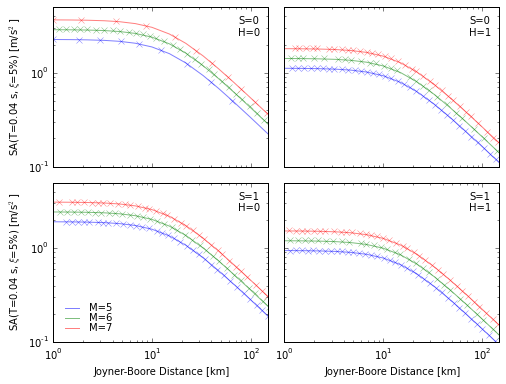

In [16]:
# produce Figure 6
digitized_template = 'digitized/M%d_S%d_H%d_%gs.csv'

Ss = sorted(list(set(df_means['S'])))
Hs = sorted(list(set(df_means['H'])))
Rjbs = sorted(list(set(df_means['dist_rjb'])))
fig, axes = plt.subplots(len(Ss), len(Hs), figsize=(8,6),
                         sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.075, hspace=0.1)
for i, S in enumerate(Ss):
    for j, H in enumerate(Hs):
        fig.sca(axes[i,j])
        df_axes = df_means[
            (df_means['S'] == S) &
            (df_means['H'] == H)]
        axis_label = 'S=%g\nH=%g' % (S, H)
        fig.gca().add_artist(AnchoredText(axis_label, loc=1, frameon=False))

        for mag in set(df_axes['rup_mag']):
            df_trace = df_axes[df_axes['rup_mag'] == mag]
                
            trace_label = 'M=%g' % mag
            h = plt.loglog(df_trace['dist_rjb'], df_trace[str(im_types[0].period)]*g, 
                       label=trace_label, alpha=0.5)
            
            digitized_file = digitized_template % (mag, S, H, im_types[0].period)
            if os.path.exists(digitized_file):
                data = np.genfromtxt(digitized_file, delimiter=',')
                plt.plot(data[:,0], data[:,1], 
                         color=h[0].get_color(), marker='x', 
                         linestyle='none', alpha=0.5)
            else:
                print '%s not available' % digitized_file
                
for ax in axes:
    ax[0].set_xlim((min(Rjbs), max(Rjbs)))
    ax[0].set_ylim((0.1, 5))
for ax in axes[1,:]:
    ax.set_xlabel('Joyner-Boore Distance [km]')
for ax in axes[:,0]:
    ax.set_ylabel('SA(T=%g s, $\\xi$=%g%%) [m/s$^2$]' 
          % (im_types[0].period, im_types[0].damping))
axes[1,0].legend(loc='lower left', labelspacing=0, fontsize=10, frameon=False)
plt.savefig('Figure_6_computed.pdf', dpi=300, bbox_inches='tight')

digitized/M5_S0_H0_50km.csv not available
digitized/M6_S0_H0_50km.csv not available
digitized/M7_S0_H0_50km.csv not available
digitized/M5_S0_H1_50km.csv not available
digitized/M6_S0_H1_50km.csv not available
digitized/M7_S0_H1_50km.csv not available


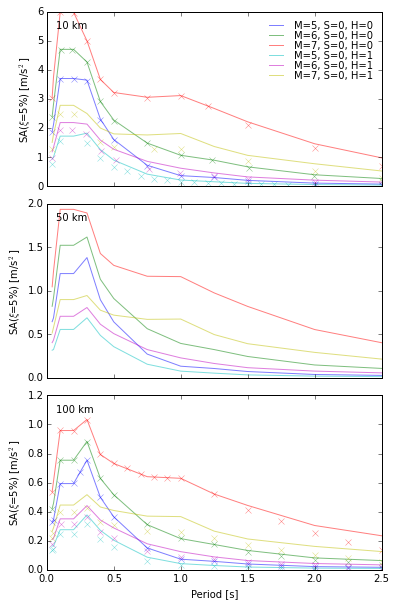

In [17]:
# produce Figures 7-9
digitized_template = 'digitized/M%d_S%d_H%d_%gkm.csv'

Ss = sorted(list(set(df_means2['S'])))
Hs = sorted(list(set(df_means2['H'])))
Rjbs = sorted(list(set(df_means2['dist_rjb'])))
fig, axes = plt.subplots(len(Rjbs), 1, figsize=(6,10), sharex=True)
plt.subplots_adjust(hspace=0.1)
for i, dist in enumerate(Rjbs):
    
    fig.sca(axes[i])
    df_axes = df_means2[df_means2['dist_rjb'] == dist]
    axis_label = '%g km' % dist
    fig.gca().add_artist(AnchoredText(axis_label, loc=2, frameon=False))
    
    S = 0
    for H in Hs:
        for mag in set(df_axes['rup_mag']):
            df_trace = df_axes[
                (df_axes['rup_mag'] == mag) &
                (df_axes['S'] == S) & 
                (df_axes['H'] == H)]
                
            trace_label = 'M=%g, S=%d, H=%d' % (mag, S, H)
            if df_trace.size == 0:
                print 'No data found for', trace_label
            
            data_trace = df_trace.loc[:,np.array(map(isnumeric, df_trace.keys()))].T
            T = [float(item) for item in data_trace.index]
            SA = data_trace.values*g
            h = plt.plot(T, SA, label=trace_label, alpha=0.5)
            
            digitized_file = digitized_template % (mag, S, H, dist)
            if os.path.exists(digitized_file):
                data = np.genfromtxt(digitized_file, delimiter=',')
                plt.plot(data[:,0], data[:,1], 
                         color=h[0].get_color(), marker='x', 
                         linestyle='none', alpha=0.5)

            else:
                print '%s not available' % digitized_file
                
for ax in axes:
    ax.set_xlim((0, max(T)))
    ax.set_ylim((0, ax.get_ylim()[1]))
axes[-1].set_xlabel('Period [s]')
for ax in axes:
    ax.set_ylabel('SA($\\xi$=%g%%) [m/s$^2$]' % (im_types[0].damping))
axes[0].legend(loc='upper right', labelspacing=0, fontsize=10, frameon=False)
plt.savefig('Figures_7-9_computed.pdf', dpi=300, bbox_inches='tight')

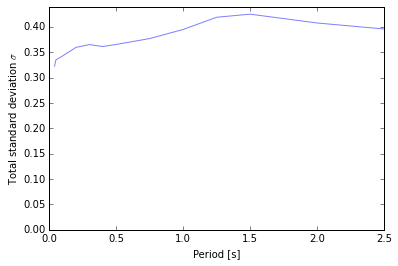

In [18]:
# produce plot of estimated residuals
Ss = sorted(list(set(df_stddevs2['S'])))
Hs = sorted(list(set(df_stddevs2['H'])))
Rjbs = sorted(list(set(df_stddevs2['dist_rjb'])))
fig, ax = plt.subplots(1, 1)

dist = Rjbs[0]   
df_axes = df_stddevs2[df_stddevs2['dist_rjb'] == dist]

S = Ss[0]
H = Hs[0]
mag = sorted(list(set(df_axes['rup_mag'])))[0]
df_trace = df_axes[
    (df_axes['rup_mag'] == mag) &
    (df_axes['S'] == S) & 
    (df_axes['H'] == H)]

trace_label = 'M=%g, S=%d, H=%d' % (mag, S, H)
if df_trace.size == 0:
    print 'No data found for', trace_label

data_trace = df_trace.loc[:,np.array(map(isnumeric, df_trace.keys()))].T
T = [float(item) for item in data_trace.index]
sigma = data_trace.values
plt.plot(T, sigma, label=trace_label, alpha=0.5)
                            
ax.set_xlim((0, max(T)))
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xlabel('Period [s]')
ax.set_ylabel('Total standard deviation $\sigma$')
plt.savefig('Sigma_computed.pdf', dpi=300, bbox_inches='tight')

In [19]:
# produce result file for unittest
test_path = '/home/nick/src/python/GEM/oq-hazardlib/openquake/hazardlib/tests/gsim/data/SDBK09/'
means_file = os.path.join(test_path, 'SDBK09_MEAN.csv')
stddev_file = os.path.join(test_path, 'SDBK09_STD_TOTAL.csv')
#df_means2.drop(['H','S'], axis=1).to_csv(means_file, index=False)
df_stddevs2.drop(['H','S'], axis=1).to_csv(stddev_file, index=False)

In [20]:
# load dataset provided by authors
ref_file = os.path.join(test_path, 'SDBK09_MEAN.csv')
df_ref = pd.read_csv(ref_file, na_values='nan')

df_ref.sort(['rup_rake','site_vs30','rup_mag','dist_rjb'], inplace=True)
df_ref.index = range(len(df_ref))

mags = np.sort(np.array(list(set(df_ref['rup_mag']))))
rakes = np.sort(np.array(list(set(df_ref['rup_rake']))))
#rakes = rakes[rakes >= 0]
Rjbs = np.sort(np.array(list(set(df_ref['dist_rjb']))))
vs30s = np.sort(np.array(list(set(df_ref['site_vs30']))))
Ts = np.sort(np.array([float(item) for item in 
     df_ref.loc[:,np.array(map(isnumeric, df_ref.keys()))]]))
im_types = [imt.SA(T) for T in Ts]

print mags, rakes, Rjbs, vs30s
print Ts

[5 6 7] [ 0 90] [ 0 10 30 60 90] [ 500 2000]
[ 0.04  0.05  0.1   0.2   0.3   0.4   0.5   0.75  1.    1.25  1.5   2.    2.5 ]


In [21]:
df_new, _ = compute_gmpe(gmpe, mags, rakes, Rjbs, vs30s, im_types)
df_new = df_new.drop(['H','S'], axis=1)
df_ref = df_ref[df_new.columns]

In [22]:
df_ref.head()

,damping,dist_rjb,rup_mag,rup_rake,site_vs30,result_type,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.75,1.0,1.25,1.5,2.0,2.5
0,5,0,5,0,500,MEAN,0.114118,0.124052,0.213486,0.213486,0.220064,0.150905,0.107059,0.049839,0.025486,0.018480,0.011591,0.006712,0.004554
1,5,10,5,0,500,MEAN,0.094830,0.102179,0.175618,0.175618,0.186026,0.128159,0.091400,0.042188,0.021489,0.015524,0.009764,0.005680,0.003911
2,5,30,5,0,500,MEAN,0.050749,0.053076,0.090827,0.090827,0.105476,0.073816,0.053584,0.024032,0.012080,0.008616,0.005470,0.003232,0.002341
3,5,60,5,0,500,MEAN,0.027405,0.027832,0.047424,0.047424,0.060297,0.042856,0.031657,0.013802,0.006847,0.004823,0.003090,0.001854,0.001411
4,5,90,5,0,500,MEAN,0.018525,0.018466,0.031380,0.031380,0.042263,0.030336,0.022658,0.009702,0.004773,0.003336,0.002149,0.001302,0.001023


In [23]:
df_new.head()

,damping,dist_rjb,rup_mag,rup_rake,site_vs30,result_type,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.75,1.0,1.25,1.5,2.0,2.5
0,5,0,5,0,500,MEAN,0.114118,0.124052,0.213486,0.213486,0.220064,0.150905,0.107059,0.049839,0.025486,0.018480,0.011591,0.006712,0.004554
1,5,10,5,0,500,MEAN,0.094830,0.102179,0.175618,0.175618,0.186026,0.128159,0.091400,0.042188,0.021489,0.015524,0.009764,0.005680,0.003911
2,5,30,5,0,500,MEAN,0.050749,0.053076,0.090827,0.090827,0.105476,0.073816,0.053584,0.024032,0.012080,0.008616,0.005470,0.003232,0.002341
3,5,60,5,0,500,MEAN,0.027405,0.027832,0.047424,0.047424,0.060297,0.042856,0.031657,0.013802,0.006847,0.004823,0.003090,0.001854,0.001411
4,5,90,5,0,500,MEAN,0.018525,0.018466,0.031380,0.031380,0.042263,0.030336,0.022658,0.009702,0.004773,0.003336,0.002149,0.001302,0.001023


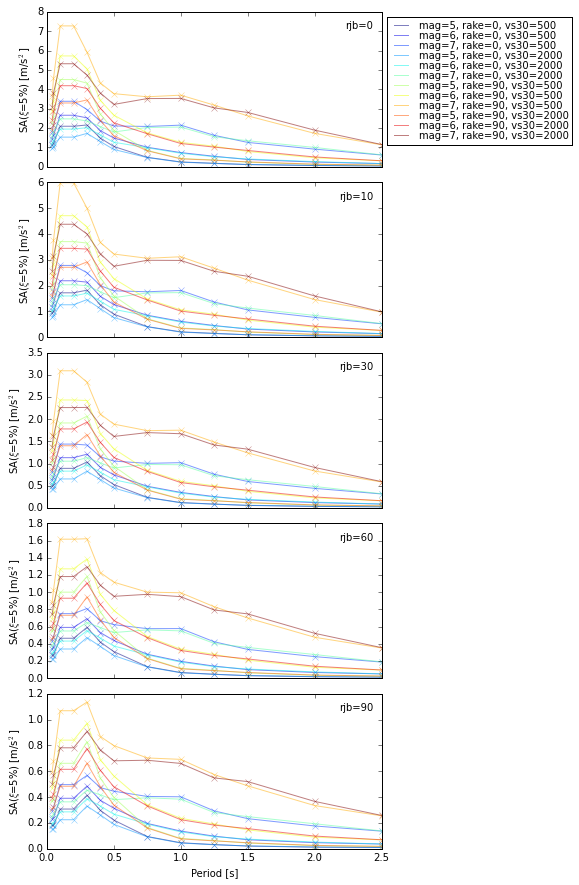

In [24]:
n_traces = len(rakes)*len(vs30s)*len(mags)
color_cycle = plt.cm.jet(np.linspace(0, 1, n_traces))

fig, axes = plt.subplots(len(Rjbs), 1, figsize=(6,15), sharex=True)
plt.subplots_adjust(hspace=0.1)
for i, dist in enumerate(Rjbs):
    
    fig.sca(axes[i])
    axis_label = 'rjb=%g' % dist
    fig.gca().add_artist(AnchoredText(axis_label, loc=1, frameon=False))
    fig.gca().set_color_cycle(color_cycle)
   
    for rake in rakes:
        for vs30 in vs30s:
            for mag in mags:
                trace_label = 'mag=%g, rake=%g, vs30=%g' % (mag, rake, vs30)
                
                df_trace = df_ref[
                    (df_ref['dist_rjb'] == dist) &
                    (df_ref['rup_mag'] == mag) &
                    (df_ref['rup_rake'] == rake) & 
                    (df_ref['site_vs30'] == vs30)]

                if df_trace.size == 0:
                    print 'No reference found for', trace_label

                data_trace = df_trace.loc[:,np.array(map(isnumeric, df_trace.keys()))].T
                SA = np.reshape(data_trace.values.T, (-1,))*g
                h = plt.plot(Ts, SA, label=trace_label, alpha=0.5)
                
                df_trace2 = df_new[
                    (df_new['dist_rjb'] == dist) &
                    (df_new['rup_mag'] == mag) &
                    (df_new['rup_rake'] == rake) & 
                    (df_new['site_vs30'] == vs30)]
                
                if df_trace2.size == 0:
                    print 'No new value found for', trace_label

                data_trace2 = df_trace2.loc[:,np.array(map(isnumeric, df_trace2.keys()))].T
                SA2 = np.reshape(data_trace2.values.T, (-1,))*g
                plt.plot(Ts, SA2, linestyle='none', marker='x', 
                         color=h[0].get_color(), alpha=0.5)
                
for ax in axes:
    ax.set_xlim((0, max(Ts)))
    ax.set_ylim((0, ax.get_ylim()[1]))
axes[-1].set_xlabel('Period [s]')
for ax in axes:
    ax.set_ylabel('SA($\\xi$=%g%%) [m/s$^2$]' % (im_types[0].damping))
axes[0].legend(loc='upper left', labelspacing=0, fontsize=10, bbox_to_anchor=(1, 1))
plt.savefig('Reference_result.png', dpi=300, bbox_inches='tight')

In [25]:
def compare(df_new, df_ref):
    numeric = np.array([[isnumeric(item) for item in row[1]] for row in df_ref.iterrows()])
    non_zero = (df_ref != 0) & numeric
    df_dif = df_ref.copy()
    df_dif = df_dif.where(~numeric, df_new.where(numeric) - df_ref.where(numeric))
    df_dif = df_dif.where(~non_zero, df_dif.where(non_zero)/df_ref.where(non_zero))
    df_dif = df_dif.where(numeric, df_new.where(~numeric) != df_ref.where(~numeric))
    
    return df_dif

In [26]:
# summarize the largest discrepancies
threshhold = 1e-8

ne_stacked = (compare(df_new, df_ref) > threshhold).stack()
changed = ne_stacked[ne_stacked]
changed.index.names = ['index', 'column']

difference_locations = np.where(compare(df_new, df_ref) > threshhold)
changed_from = df_new.values[difference_locations]
changed_to = df_ref.values[difference_locations]
pd.DataFrame({'from': changed_from, 'factor': changed_from/changed_to}, index=changed.index)

factor         from
index column                    
3     2.0         1  0.001853986
4     2.5         1  0.001023058
17    2.5         1  0.002369888
18    2.0         1  0.002032855
19    1.5         1  0.002294732
      2.0         1  0.001428015
      2.5         1  0.001035859
24    2.5         1  0.003822966

In [27]:
g

9.80665

In [28]:
type(bool)

type